<!-- ---
title: "Week 6"
title-block-banner: true
title-block-style: default
execute:
  freeze: true
  cache: true
format: html
# format: pdf
--- -->

In [239]:
dir <- "~/work/courses/stat380/weeks/week-11/"
setwd(dir)


#### Packages we will require this week

In [240]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "glmnet",
    "caret",
    "repr",
    "tidyverse",
    "mlbench",
    "nnet",
    "rpart",
    "e1071",
    # NEW
    "torch",
    "torchvision",
    "luz"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

ISLR2       dplyr       tidyr       readr       purrr      glmnet 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      caret        repr   tidyverse     mlbench        nnet       rpart 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      e1071       torch torchvision         luz 
       TRUE        TRUE        TRUE        TRUE

# Recap

---


## Regression with Neural Networks

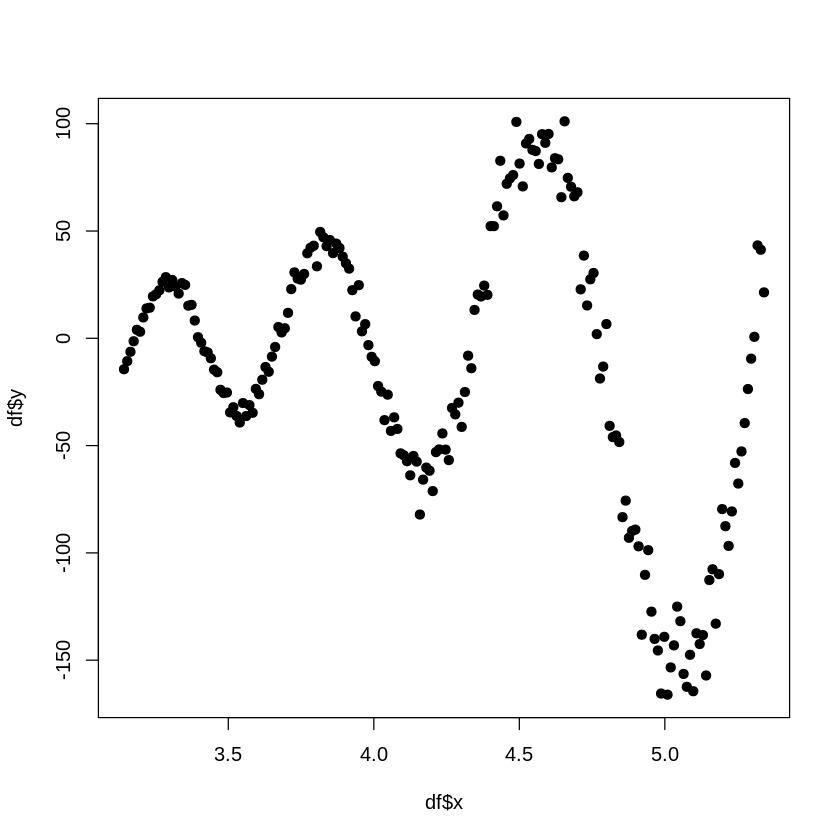

In [16]:
generate_data <- function(n, noise = 0.1) {
  x <- seq(1*pi, 1.7*pi, length.out = n)
  y <- exp(x) * (sin(150/x) + rnorm(n, 0, noise))
  data.frame(x = x, y = y)
}

df <- generate_data(200, noise=0.1)
plot(df$x, df$y, pch = 19)

In [17]:
x_new <- seq(0.9 * pi, 2.1 * pi, length.out=1000)
df_new <- data.frame(x = x_new)

plt_reg <- function(f, x,...){
    ynew <- f(x)
    ylim <- range(c(ynew, df$y))
    ylim[1] <- max(c(-800, ylim[1]))
    ylim[2] <- min(c(250, ylim[2]))
    xlim <- range(x)
    
    plot(df$x, df$y, pch = 22, col="red", xlim=xlim, ylim=ylim,...)
    points(x[, 1], ynew, pch=22, type="l")
}

---

### Neural Network

In [18]:
p <- 1
q1 <- 20
q2 <- 100

reg_module <- nn_module(
  initialize = function() {
    self$input_to_hidden1 <- nn_linear(p, q1)
    self$hidden1_to_hidden2 <- nn_linear(q1, q2)
    self$hidden2_to_output <- nn_linear(q2, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$input_to_hidden1() %>% 
      self$activation() %>% 
      self$hidden1_to_hidden2() %>% 
      self$activation() %>% 
      self$hidden2_to_output()
  }
)

In [27]:
regressor <- 
function(train, type="nn", ...){
    
    if(type == "lm"){
        f = \(x) lm(y ~ x, df) %>% 
                    predict(., x)
    }
    
    else if(type == "rpart"){
        f = \(x) 
            rpart(y ~ x, df) %>% 
            predict(., x)
    }
        
    else if(type == "svm"){
        f = \(x)
            svm(y ~ x, df, kernel="radial") %>% 
            predict(., x)
    } 
        
    else if(type == "nn"){
        X_tensor <- torch_tensor(cbind(df$x %>% as.matrix()), dtype=torch_float())
        y_tensor <- torch_tensor(cbind(df$y %>% as.matrix()), dtype=torch_float())
        F <- reg_module()
        optimizer <- optim_adam(F$parameters, lr=0.2)
        epochs <- 1000

        for(i in 1:epochs){
            loss <- nn_mse_loss()(F(X_tensor), y_tensor)
            optimizer$zero_grad()
            loss$backward()
            optimizer$step()
        }
        f = \(x) as_array(F( torch_tensor(x %>% as.matrix(), dtype=torch_float()) ))
    }
    
    return(f)
}

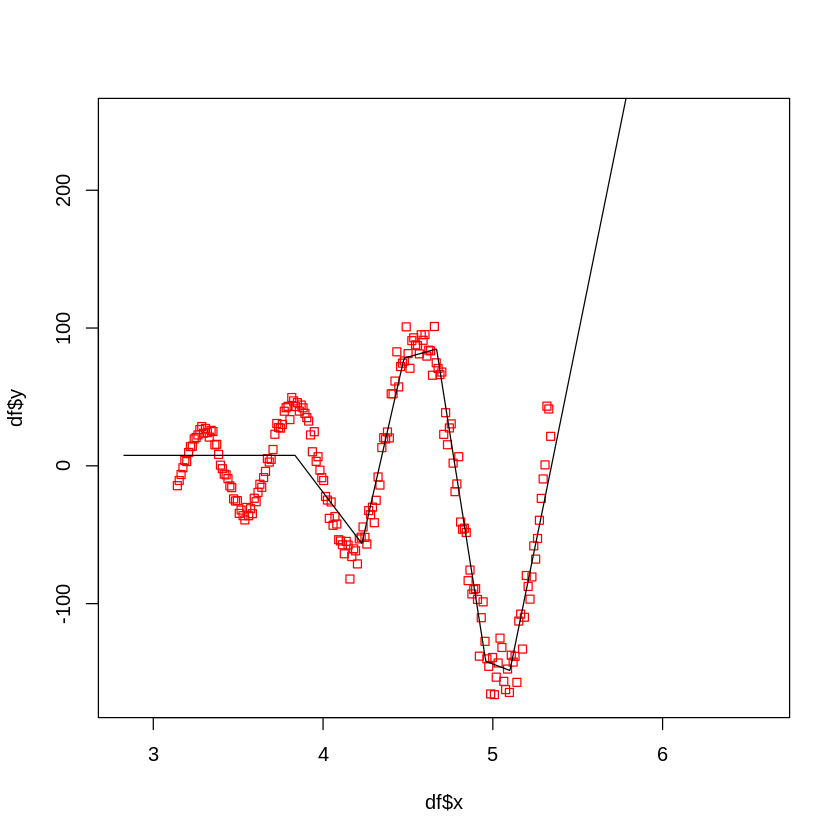

In [28]:
f <- regressor(df, "nn")
plt_reg(f, df_new)

---

## Classification with Neural Networks

In [4]:
ex <- \(x) ifelse(
    ((abs(x[1]) + 0.05 * rnorm(1)  > 0.50 && abs(x[2]) + 0.05 * rnorm(1)  > 0.50)) || 
    ((abs(x[1]) + 0.05 * rnorm(1)  < 0.25 && abs(x[2]) + 0.05 * rnorm(1)  < 0.25)),
    1, 0
)

gen_classification_data <- function(n=500){
    X <- t(replicate(n, 2 * runif(2) - 1))
    y <- apply(X, 1, ex) %>% as.factor()
    col <- ifelse(y == 0, "blue", "red")
    df <- data.frame(y = y, x1 = X[, 1], x2 = X[, 2], col=col)
    return(df)
}

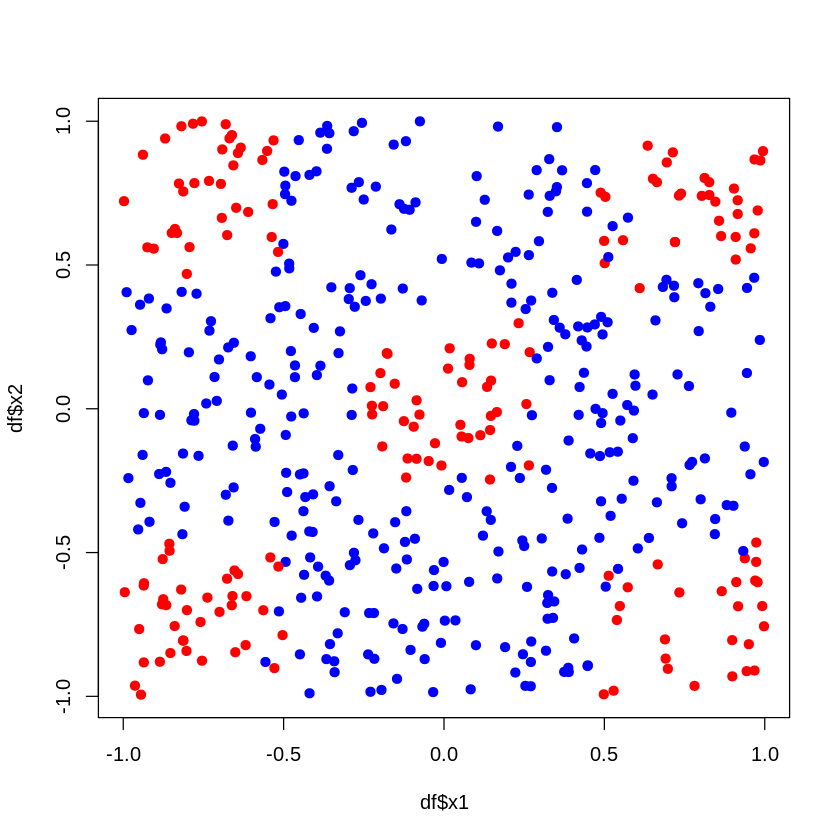

In [5]:
df <- gen_classification_data(500)
plot(df$x1, df$x2, col = df$col, pch = 19)

In [6]:
Xnew <- cbind(
    rep(seq(-1.1, 1.1, length.out=50), 50),
    rep(seq(-1.1, 1.1, length.out=50), each = 50)
)

df_new = data.frame(x1=Xnew[, 1], x2=Xnew[, 2])

plt <- function(f, x){
    plot(x[, 1], x[, 2], col=ifelse(f(x) < 0.5, "blue", "red"), pch=22)
    points(df$x1, df$x2, col= ifelse(y == "0", "blue", "red"), pch = 19)
}

overview <- function(f){
    predicted <- ifelse(f(df[, -1]) < 0.5, 0, 1)
    actual <- df[, 1]
    table(predicted, actual)
}

### Neural Network with 1 hidden layer
---

In [7]:
p <- 2
q <- 20

hh1_module <- nn_module(
  initialize = function() {
      
    self$input_to_hidden <- nn_linear(p, q)
      
    self$hidden_to_output <- nn_linear(q, 1)
      
    self$activation <- nn_relu()
      
    self$sigmoid <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$input_to_hidden() %>% 
      self$activation() %>% 
      self$hidden_to_output() #%>% 
      self$sigmoid()
  }
)


q1 <- 100
q2 <- 20

hh2_module <- nn_module(
  initialize = function() {
    self$input_to_hidden1 <- nn_linear(p, q1)
    self$hidden1_to_hidden2 <- nn_linear(q1, q2)
    self$hidden2_to_output <- nn_linear(q2, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
  forward = function(x) {
    x %>% 
      self$input_to_hidden1() %>% 
      self$activation() %>% 
      self$hidden1_to_hidden2() %>% 
      self$activation() %>% 
      self$hidden2_to_output() %>% 
      self$sigmoid()
  }
)

---

In [8]:
classifier <- 
function(train, type="nn", ...){
    
    if(type == "logistic"){
        f = \(x) glm(y ~ x1 + x2, train, family=binomial()) %>% 
                 predict(., x, type="response")
    }
    
    else if(type == "rpart"){
        f = \(x) 
            rpart(y ~ x1 + x2, df, method="class") %>% 
            predict(., x, type="class") %>% 
            as.numeric(.) - 1
    }
        
    else if(type == "svm"){
        f = \(x)
            svm(y ~ x1 + x2, df, kernel="radial") %>% 
            predict(., x) %>% 
            as.numeric(.) - 1
    } 
        
    else if(type == "nn"){
        X_tensor <- torch_tensor(train[, -1] %>% as.matrix(), dtype=torch_float())
        y_tensor <- torch_tensor(cbind(train$y %>% as.numeric() - 1), dtype=torch_float())
        F <- hh2_module()
        optimizer <- optim_adam(F$parameters, lr=0.05)
        epochs <- 1000

        for(i in 1:epochs){
            loss <- nn_bce_loss()(F(X_tensor), y_tensor)
            optimizer$zero_grad()
            loss$backward()
            optimizer$step()
        }
        f = \(x) as_array(F( torch_tensor(x %>% as.matrix(), dtype=torch_float()) ))
    }
    
    return(f)
}

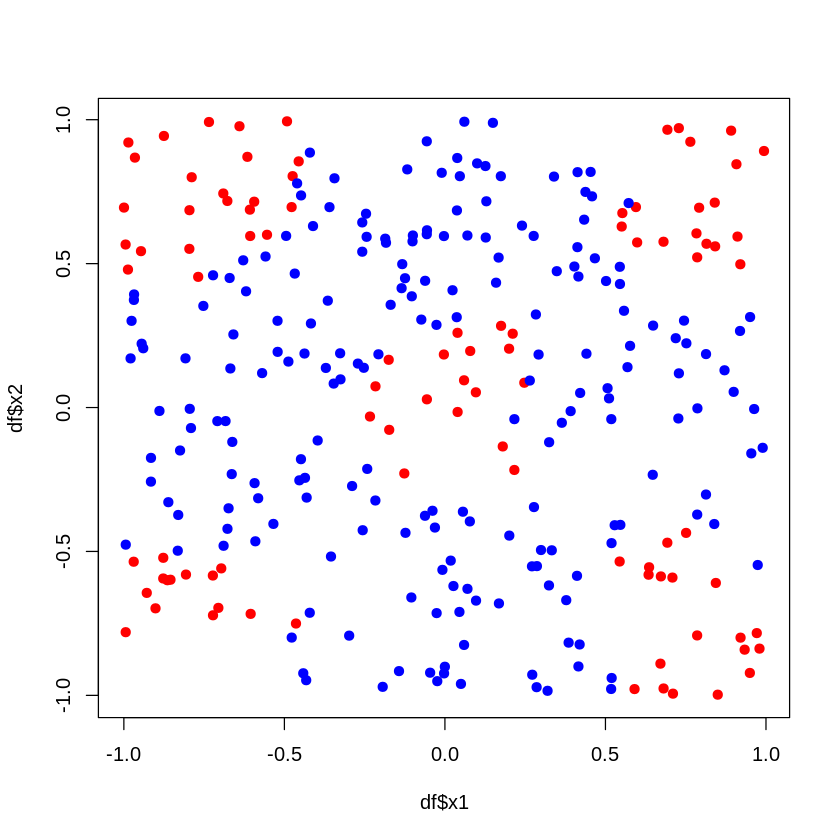

In [9]:
ex <- \(x) ifelse(
    ((abs(x[1]) + 0.05 * rnorm(1)  > 0.50 && abs(x[2]) + 0.05 * rnorm(1)  > 0.50)) || 
    ((abs(x[1]) + 0.05 * rnorm(1)  < 0.25 && abs(x[2]) + 0.05 * rnorm(1)  < 0.25)),
    1, 0
)


n <- 300
X <- t(replicate(n, 2 * runif(2) - 1))
y <- apply(X, 1, ex) %>% as.factor()
col <- ifelse(y == 0, "blue", "red")
df <- data.frame(y = y, x1 = X[, 1], x2 = X[, 2])
plot(df$x1, df$x2, col = col, pch = 19)

Xnew <- cbind(
    rep(seq(-1.1, 1.1, length.out=50), 50),
    rep(seq(-1.1, 1.1, length.out=50), each = 50)
)

df_new = data.frame(x1=Xnew[, 1], x2=Xnew[, 2])

         actual
predicted   0   1
        0 216   0
        1   1  83

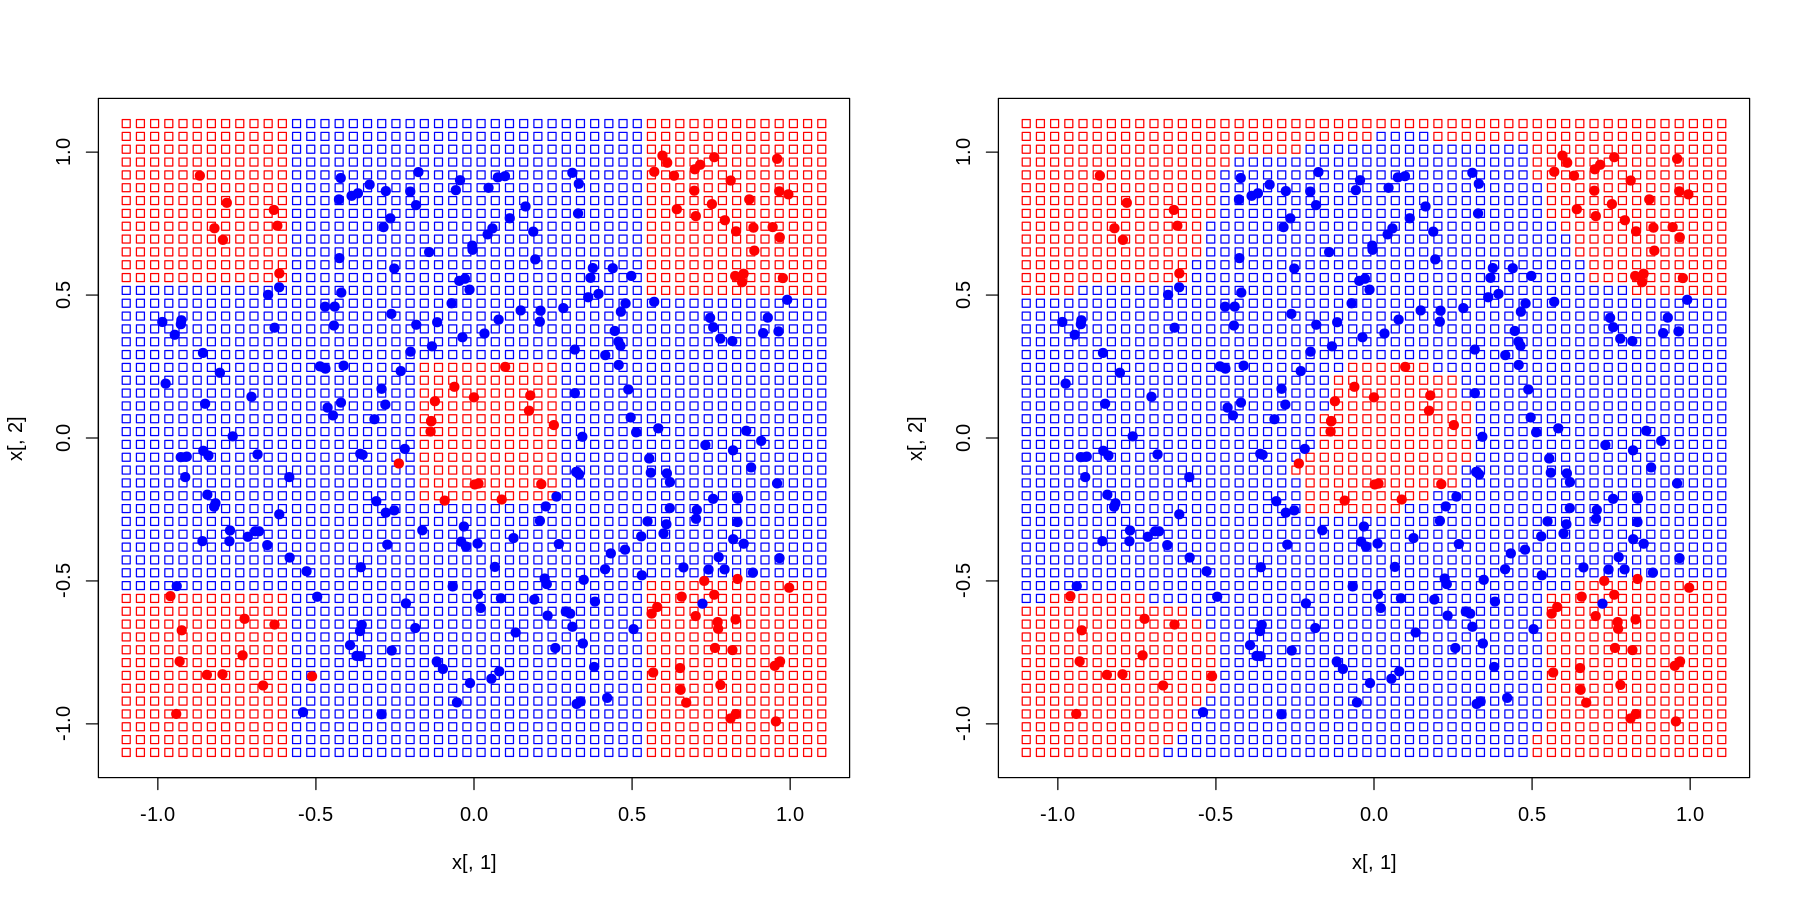

In [51]:
options(repr.plot.width=15, repr.plot.height=7.5)
par(mfrow=c(1,2))

f <- classifier(df, "rpart")
plt(f, df_new)

f <- classifier(df, "nn")
plt(f, df_new)

overview(f)

---

# Thu, Apr 6

### Agenda:

1. Introduction to `Luz`
1. Dataloaders
1. Torch for image classification

### Luz

Luz is a higher level API for torch providing abstractions to allow for much less verbose training loops.

---

#### Allowing hyperparameters for NNs

In [250]:
nn_model <- nn_module(
  initialize = function(p, q1) {  
    self$hidden1 <- nn_linear(p, q1)
    self$output <- nn_linear(q1, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% 
      self$activation() %>% 
      self$output() %>% 
      self$sigmoid()
  }
)

In [254]:
x <- torch_randn(10, 10000)
x

torch_tensor
Columns 1 to 6 1.4010e+00 -1.2329e+00 -2.2016e+00 -4.8081e-01  3.1154e-01  8.8710e-01
-1.6105e-01 -3.8740e-01 -6.5329e-01  4.7093e-01  1.9826e-01  2.0003e+00
 8.1819e-02  8.1723e-01 -1.4216e+00  5.3220e-01  1.1152e-01  2.8251e-01
-6.6128e-01  3.8899e-01 -6.7792e-01 -6.8115e-01 -1.6463e+00 -1.8106e+00
 4.9751e-01 -3.4224e-01  3.2567e-01  9.0241e-01  5.0749e-01 -4.2336e-01
 1.1880e+00 -1.3764e+00  1.1916e+00  4.3597e-01  2.0274e+00 -1.8185e-01
 8.6390e-01  6.2809e-01  8.2772e-01 -1.3189e+00  7.4576e-01 -4.1591e-01
 6.1304e-01 -5.9085e-02 -4.8724e-01  4.0909e-01  3.7476e-01 -1.2111e+00
 8.9178e-01  1.0277e+00 -5.5846e-01 -1.5899e+00 -2.8453e-01 -3.3655e-01
 4.6993e-01  1.0073e+00 -4.5889e-01  1.2320e+00  3.0980e-01 -1.9743e+00

Columns 7 to 12-8.5515e-01 -5.5192e-01  1.4434e+00  3.4203e-01 -2.3928e+00  3.5501e-01
 7.6627e-02 -3.4422e-01 -1.2640e+00  2.1857e-01  3.0190e-01 -7.6928e-02
 4.4555e-01  6.0017e-01  1.5071e+00 -4.3174e-01 -5.1802e-01  1.0341e+00
 1.6873e-01  1.0639e+

In [255]:
nn_model(p=10000, q1=10)(x)

torch_tensor
 0.5877
 0.5968
 0.5484
 0.5648
 0.5163
 0.5398
 0.6025
 0.5134
 0.5012
 0.5506
[ CPUFloatType{10,1} ][ grad_fn = <SigmoidBackward0> ]

---

#### Luz Setup

In [260]:
nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam
    )

<luz_module_generator>

> This is equivalent to specifying:
>
> ```
> F <- nn_model()
> opt <- optim_adam(F$parameters)
> ...
> for(i in 1:...){
>     loss <- nn_bce_loss()(x, f(y))
>     ...
> }
> ```

----

#### Luz hyperparameters

In [272]:
nn_model <- nn_module(
  initialize = function(p, q1, q2, q3) {  
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$output <- nn_linear(q3, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% self$activation() %>% 
      self$hidden2() %>% self$activation() %>% 
      self$hidden3() %>% self$activation() %>% 
      self$output() %>% self$sigmoid()
  }
)

In [273]:
nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam
    ) %>% 
    set_hparams(p=2, q1=5, q2=7, q3=5) %>% 
    set_opt_hparams(lr=0.02)

<luz_module_generator>

> This is now equivalent to specifying:
>
> ```
> F <- nn_model(p=2, q1=5, q2=7, q3=5)
> opt <- optim_adam(lr=0.02)
> ...
> for(i in 1:...){
>     loss <- nn_bce_loss()(x, f(y))
>     ...
> }
> ```

---

#### Luz Fit

In [274]:
fit_nn <- nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam
    ) %>% 
    set_hparams(p=2, q1=5, q2=7, q3=5) %>% 
    set_opt_hparams(lr=0.02) %>%
    ### Fit the neural network
    fit(
        data = list(
            as.matrix(df[, -1]),
            as.numeric(df[, 1]) - 1
        ),
        epochs = 10,
        verbose=TRUE
    )

Epoch 1/10
Train metrics: Loss: 0.7142
Epoch 2/10
Train metrics: Loss: 0.6134
Epoch 3/10
Train metrics: Loss: 0.6202
Epoch 4/10
Train metrics: Loss: 0.5987
Epoch 5/10
Train metrics: Loss: 0.5789
Epoch 6/10
Train metrics: Loss: 0.5704
Epoch 7/10
Train metrics: Loss: 0.5598
Epoch 8/10
Train metrics: Loss: 0.5386
Epoch 9/10
Train metrics: Loss: 0.5001
Epoch 10/10
Train metrics: Loss: 0.4943


> This now becomes equivalent to:
>
> ```
> F <- nn_model(p=2, q1=5, q2=7, q3=5)
> opt <- optim_adam(lr=0.02)
>
> x <- torch_tensor(as.matrix(df[, -1]),     dtype=torch_float())
> y <- torch_tensor(as.numeric(df[, 1]) - 1, dtype=torch_float())
>
> for(i in 1:epochs){
>     loss <- nn_bce_loss()(x, f(y))
>     optimizer\$zero_grad()
>     loss\$backward()
>     optimizer\$step()
>     print(paste0("Train metrics: Loss: ", loss))
> }
> ```

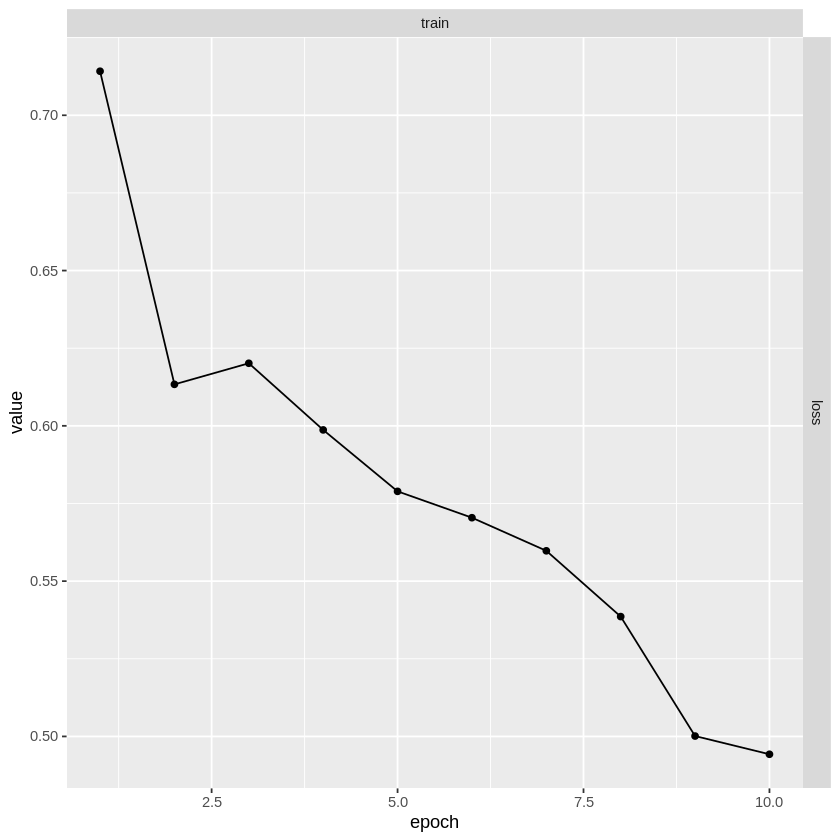

In [275]:
plot(fit_nn)

The output of Luz allows you to use the familiar predict function

In [279]:
predict(fit_nn, cbind(rnorm(10), rnorm(10))) %>% as_array

0.2686929
0.9927400
0.2655984
0.2650835
0.2650835
0.2060661
0.9490728
0.9041664
0.2650835
0.2088126


---

#### Luz validation Data

In [281]:
test_ind <- sample(1:nrow(df), 23, replace=FALSE)

In [283]:
fit_nn <- nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam
    ) %>% 
    set_hparams(p=2, q1=5, q2=7, q3=5) %>% 
    set_opt_hparams(lr=0.02) %>%
    ### Fit the neural network
    fit(
        data = list(
            as.matrix(df[-test_ind, -1]),
            as.numeric(df[-test_ind, 1]) - 1
        ),
        valid_data = list(
            as.matrix(df[+test_ind, -1]),
            as.numeric(df[+test_ind, 1]) - 1
        ),
        epochs = 10,
        verbose=TRUE
    )

Epoch 1/10
Train metrics: Loss: 0.636
Valid metrics: Loss: 0.7336
Epoch 2/10
Train metrics: Loss: 0.6053
Valid metrics: Loss: 0.7588
Epoch 3/10
Train metrics: Loss: 0.6005
Valid metrics: Loss: 0.7671
Epoch 4/10
Train metrics: Loss: 0.5886
Valid metrics: Loss: 0.7558
Epoch 5/10
Train metrics: Loss: 0.5739
Valid metrics: Loss: 0.7384
Epoch 6/10
Train metrics: Loss: 0.5458
Valid metrics: Loss: 0.7488
Epoch 7/10
Train metrics: Loss: 0.5294
Valid metrics: Loss: 0.7838
Epoch 8/10
Train metrics: Loss: 0.5126
Valid metrics: Loss: 0.744
Epoch 9/10
Train metrics: Loss: 0.4933
Valid metrics: Loss: 0.764
Epoch 10/10
Train metrics: Loss: 0.4529
Valid metrics: Loss: 0.6587


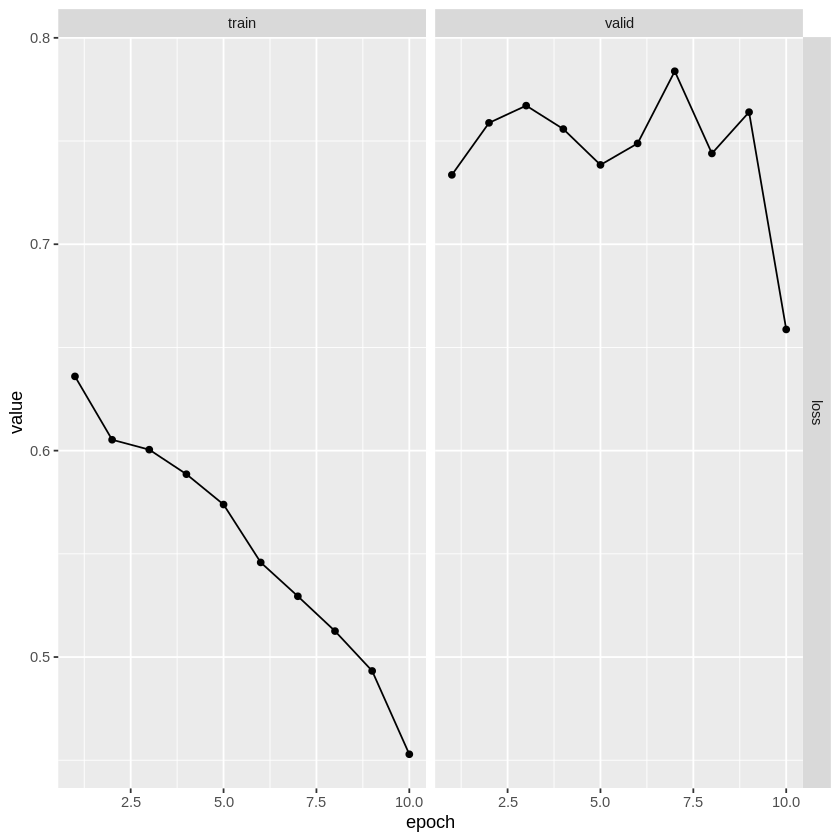

In [284]:
plot(fit_nn)

---

#### Luz metrics

Luz metrics allow you to examine metrics other than the loss function during the NNet training procedure

In [289]:
predicted <- torch_tensor( sample(0:1, 100, replace=TRUE) )
expected <- torch_tensor( sample(0:1, 100, replace=TRUE) )

metric <- luz_metric_binary_accuracy()

metric <- metric$new()
metric$update(expected, expected)
metric$compute()

[1] 1

>predicted <- torch_cat(list(torch_zeros(50), torch_ones(50)))
>
>expected <- torch_cat(list(torch_ones(50), torch_zeros(50)))
>
>metric <- luz_metric_binary_accuracy()

In [203]:
nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam,
        # Specify the metrics you want to examine
        metrics = list(
            luz_metric_binary_accuracy(),
            luz_metric_binary_auroc()
        )
    )

<luz_module_generator>

----

#### Putting it all together

In [293]:
fit_nn <- nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam,
        metrics = list(
            luz_metric_binary_accuracy(),
            luz_metric_binary_auroc()
        )
    ) %>% 
    set_hparams(p=2, q1=5, q2=7, q3=5) %>% 
    set_opt_hparams(lr=0.01) %>%
    ### Fit the neural network
    fit(
        data = list(
            as.matrix(df[-test_ind, -1]),
            as.numeric(df[-test_ind, 1]) - 1
        ),
        valid_data = list(
            as.matrix(df[+test_ind, -1]),
            as.numeric(df[+test_ind, 1]) - 1
        ),
        epochs = 100,
        verbose=TRUE
    )

Epoch 1/100
Train metrics: Loss: 0.7009 - Acc: 13.556 - AUC: 0.4491
Valid metrics: Loss: 0.6928 - Acc: 12 - AUC: 0.3788
Epoch 2/100
Train metrics: Loss: 0.6349 - Acc: 21.6209 - AUC: 0.5311
Valid metrics: Loss: 0.7222 - Acc: 12 - AUC: 0.4924
Epoch 3/100
Train metrics: Loss: 0.6035 - Acc: 21.6606 - AUC: 0.5809
Valid metrics: Loss: 0.7828 - Acc: 12 - AUC: 0.5152
Epoch 4/100
Train metrics: Loss: 0.5953 - Acc: 21.5812 - AUC: 0.6076
Valid metrics: Loss: 0.7528 - Acc: 12 - AUC: 0.5909
Epoch 5/100
Train metrics: Loss: 0.5909 - Acc: 21.7004 - AUC: 0.6234
Valid metrics: Loss: 0.7328 - Acc: 12 - AUC: 0.5985
Epoch 6/100
Train metrics: Loss: 0.5803 - Acc: 21.7401 - AUC: 0.6629
Valid metrics: Loss: 0.7333 - Acc: 12 - AUC: 0.6288
Epoch 7/100
Train metrics: Loss: 0.5677 - Acc: 21.3249 - AUC: 0.697
Valid metrics: Loss: 0.7105 - Acc: 12 - AUC: 0.6591
Epoch 8/100
Train metrics: Loss: 0.5531 - Acc: 21.2888 - AUC: 0.7142
Valid metrics: Loss: 0.727 - Acc: 12 - AUC: 0.6364
Epoch 9/100
Train metrics: Loss: 0.

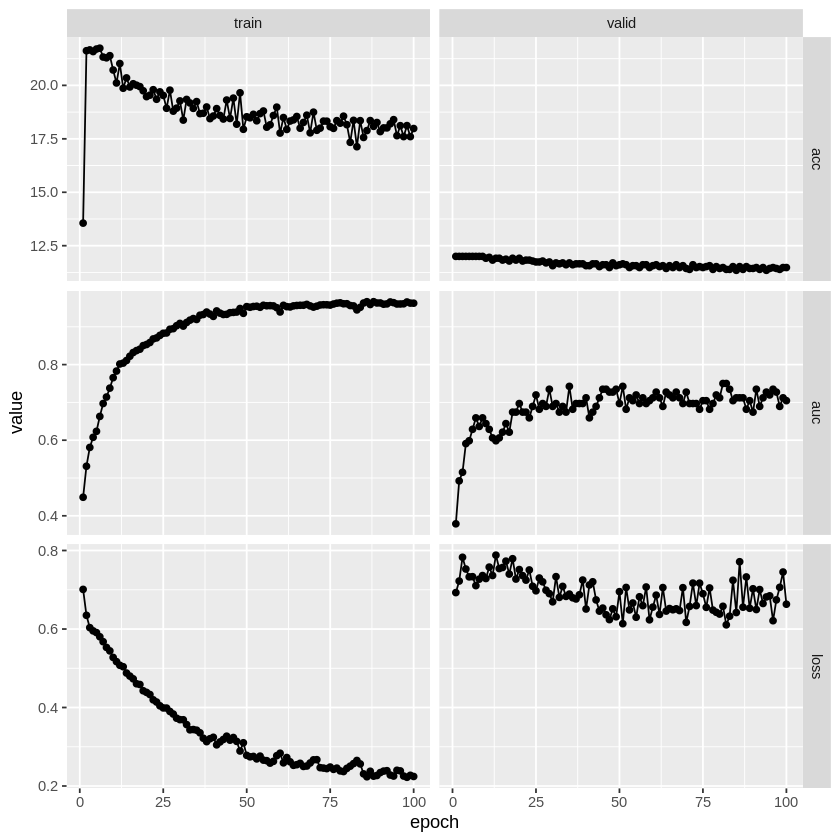

In [294]:
plot(fit_nn)

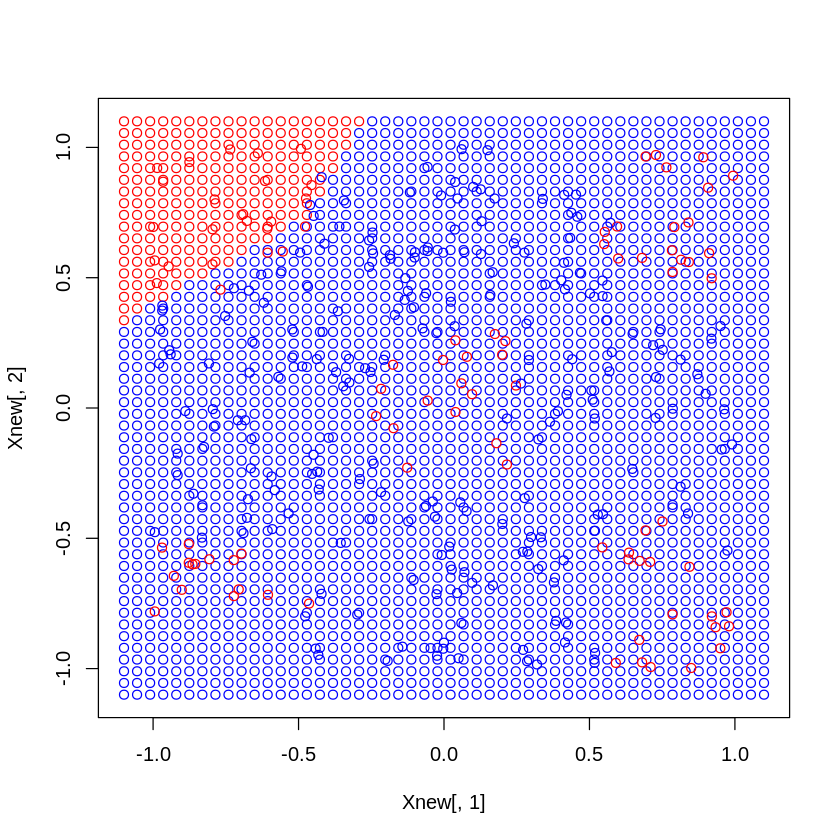

In [231]:
cols <- ifelse(as_array(predict(fit_nn, Xnew)) > 0.5, "red", "blue")
plot(Xnew[, 1], Xnew[, 2], col=cols)
points(df$x1, df$x2, col=col)

---

#### Final result

In [236]:
fit_nn <- nn_model %>%
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adam,
        metrics = list(
            luz_metric_binary_accuracy()
        )
    ) %>%
    set_hparams(p = 2, q1=20, q2=100, q3=20) %>% 
    set_opt_hparams(lr=0.01) %>% 
    
    # Fitting the actual model
    fit(
        data = list(
            as.matrix(df[-test_ind, -1]),
            as.numeric(df[-test_ind, 1]) - 1
        ),
        valid_data = list(
            as.matrix(df[test_ind, -1]),
            as.numeric(df[test_ind, 1]) - 1
        ),
        epochs = 500,
        verbose=FALSE
    )

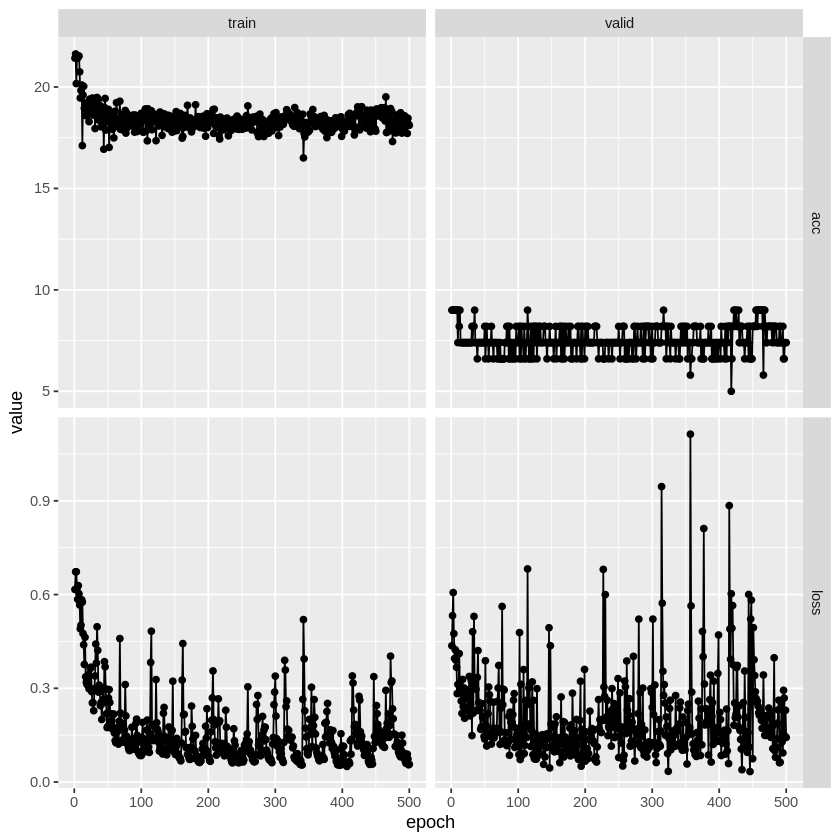

In [237]:
plot(fit_nn)

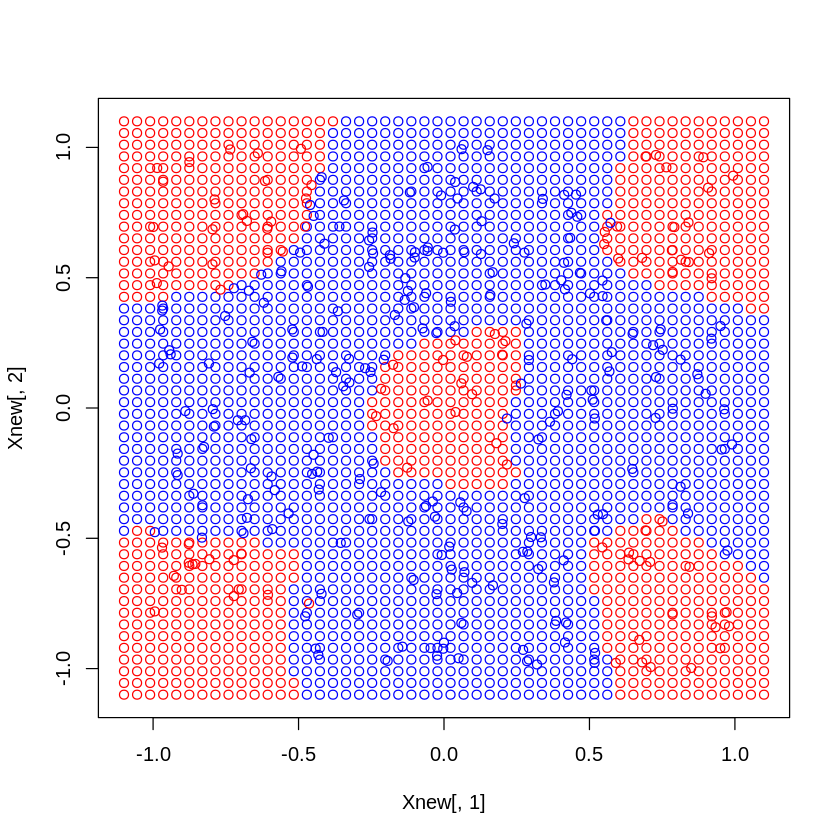

In [238]:
cols <- ifelse(as_array(predict(fit_nn, Xnew)) > 0.5, "red", "blue")
plot(Xnew[, 1], Xnew[, 2], col=cols)
points(df$x1, df$x2, col=col)

<br><br><br><br><br><br><br>
<br><br><br><br><br><br><br>
<br><br><br><br><br><br><br>
<br><br><br><br><br><br><br>

In [15]:
library(ISLR2)
df <- na.omit(Hitters)
n <- nrow(df)

In [16]:
head(df)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
-Al Newman,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.0,A


In [30]:
x <- scale(model.matrix(Salary ~ . - 1, data = df))
y <- df$Salary
head(x)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,LeagueA,LeagueN,DivisionW,PutOuts,Assists,Errors,NewLeagueN
-Alan Ashby,-0.6017532,-0.5945419,-0.5275454,-1.2038163,-0.52106946,-0.09734151,1.3952334,0.3461306,0.1740416,-0.002914243,-0.1214393,0.25847281,0.43450593,-1.0567429,1.0567429,0.9792988,1.21917406,-0.52219572,0.2129461,1.0730066
-Alvin Davis,0.5115664,0.4913228,0.7285771,0.4406748,0.79254856,1.60631004,-0.8994853,-0.4520036,-0.4091121,-0.075909091,-0.4143150,-0.19921055,0.01035326,0.9427059,-0.9427059,0.9792988,2.10509535,-0.25337958,0.8184036,-0.9284171
-Andre Dawson,0.6269715,0.7350884,0.9569630,0.4015202,1.02436351,-0.18943079,0.7694010,1.2990809,1.3156652,1.894951816,1.4093644,1.56967378,0.35497730,-1.0567429,1.0567429,-1.0172561,-0.32404367,-0.74276281,-0.8466046,1.0730066
-Andres Galarraga,-0.5610220,-0.4615789,-0.1849665,-0.6164981,-0.36652617,-0.51174324,-1.1080961,-0.9890495,-0.9583256,-0.696365303,-0.9457182,-0.87955068,-0.86067453,-1.0567429,1.0567429,-1.0172561,1.83717561,-0.54287389,-0.6952402,1.0730066
-Alfredo Griffin,1.2922478,1.3555825,-0.8701243,0.7539112,-0.01880375,-0.28152006,0.7694010,0.7655337,0.6337765,-0.611204646,0.4220413,0.01726131,-0.25095507,0.9427059,-0.9427059,0.9792988,-0.03111808,2.08325298,2.4834118,-0.9284171
-Al Newman,-1.4842626,-1.5696041,-1.2127031,-1.2429709,-1.68014419,-0.92614497,-1.1080961,-1.0686443,-1.0493469,-0.830189192,-1.0000663,-0.99397151,-0.89475822,-1.0567429,1.0567429,-1.0172561,-0.76700431,0.05679288,-0.2411471,-0.9284171


In [18]:
h1_nn <- nn_module(
  initialize = function(p, q) {
    self$hidden <- nn_linear(p, q)
    self$activation <- nn_relu()
    self$output <- nn_linear(q, 1)
  },
  forward = function(x) {
    x %>% 
      self$hidden() %>% 
      self$activation() %>% 
      self$output()
  }
)

In [19]:
h1_nn <- h1_nn %>% 
  setup(
    loss = nn_mse_loss(),
    optimizer = optim_adam,
    metrics = list(luz_metric_mse())
  ) %>% 
  set_hparams(p = ncol(x), q=50)

In [20]:
set.seed(13)
ntest <- round(n / 3, digits=0)
testid <- sample(1:n, ntest)

In [32]:
data = list(
    torch_tensor(as.matrix(x[-testid, ]), dtype=torch_float()),
    torch_tensor(as.matrix(y[-testid]), dtype=torch_float())
)

In [36]:
fitted <- h1_nn %>% 
  fit(
    data = list(x[-testid, ], matrix(y[-testid], ncol = 1)),
    valid_data = list(x[testid, ], matrix(y[testid], ncol = 1)),
    epochs = 500 # 50
  )

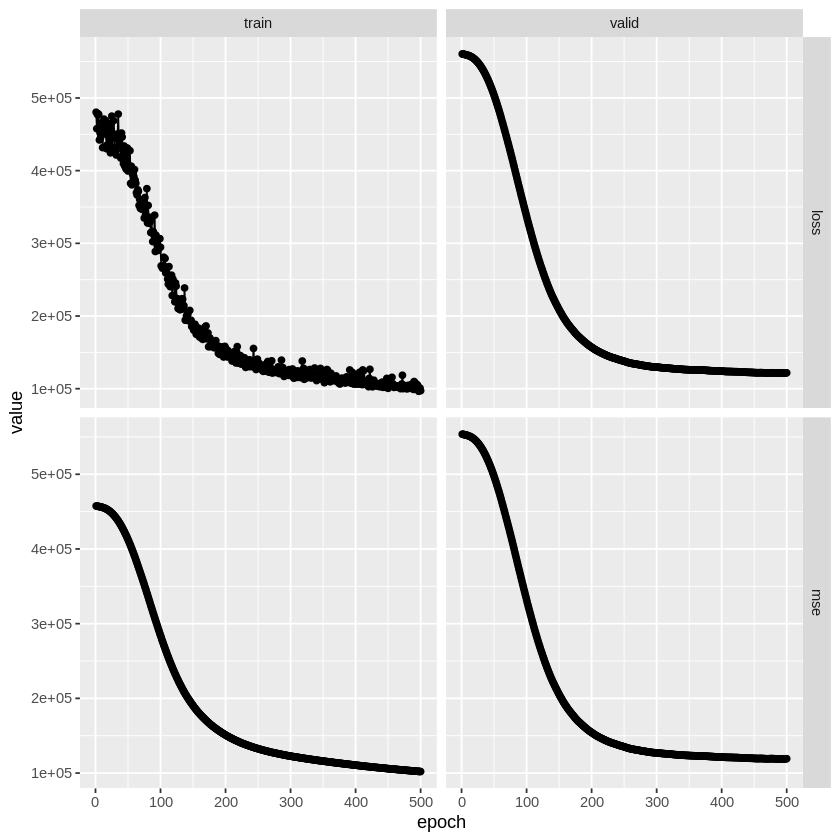

In [37]:
plot(fitted)

---

In [94]:
dir <- "./mnist" # caching directory

# Modify the MNIST dataset so the target is identical to the input.
mnist_dataset2 <- torch::dataset(
  inherit = mnist_dataset,
  .getitem = function(i) {
    output <- super$.getitem(i)
    output$y <- output$x
    output
  }
)

train_ds <- mnist_dataset2(
  dir,
  download = TRUE,
  transform = transform_to_tensor
)

test_ds <- mnist_dataset2(
  dir,
  train = FALSE,
  transform = transform_to_tensor
)

train_dl <- dataloader(train_ds, batch_size = 128, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 128)

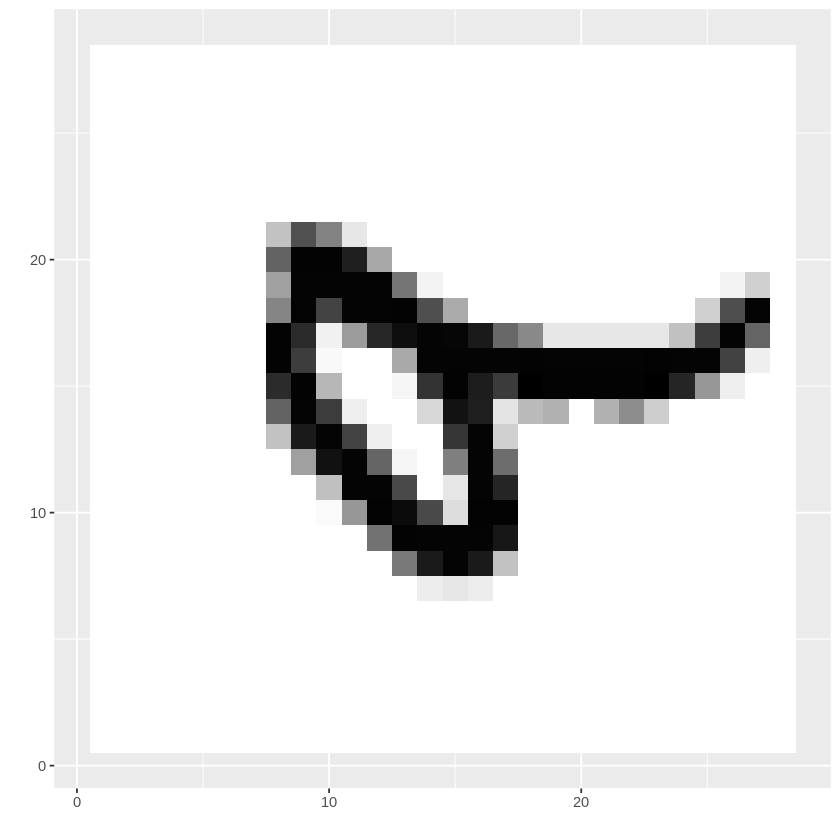

In [89]:
library(reshape2)

image <- train_ds$data[sample(1:100, 1),1:28,1:28]

image_df <- melt(image)


ggplot(image_df, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(show.legend = FALSE) + 
  xlab("") + ylab("") +
  scale_fill_gradient(low="white", high="black")

In [96]:
net <- nn_module(
  "Net",
  
  initialize = function() {
    self$conv1 <- nn_conv2d(1, 32, 3, 1)
    self$conv2 <- nn_conv2d(32, 64, 3, 1)
    self$fc1 <- nn_linear(9216, 128)
    self$fc2 <- nn_linear(128, 10)
  },
  
  forward = function(x) {
    x %>%
      self$conv1() %>%
      nnf_relu() %>%
      self$conv2() %>%
      nnf_relu() %>%
      nnf_max_pool2d(2) %>%
      torch_flatten(start_dim = 2) %>%
      self$fc1() %>%
      nnf_relu() %>%
      self$fc2()
  }
)

In [97]:
fitted <- net %>%
  setup(
    loss = nn_cross_entropy_loss(),
    optimizer = optim_adam,
    metrics = list(
      luz_metric_accuracy()
    )
  ) %>%
  fit(train_dl, epochs = 10, valid_data = test_dl)

ERROR: Error in to_index_tensor(target): Indexing starts at 1 but found a 0.
